In [1]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
import nibabel as nib
from scipy.stats import zscore
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pickle

subjects =  ['sub-EZ9NM','sub-TV7EF','sub-WLC4O','sub-3L109','sub-3UYSS','sub-JVPPA','sub-EDOP8',
             'sub-TIJD1','sub-AYDLR','sub-98UT7','sub-4G9A5','sub-YJBI8','sub-FG8PD','sub-BBN4K',
             'sub-F61IR','sub-M1ZRL','sub-NZJZN','sub-XZ9SS','sub-L05R3','sub-ZOVPY','sub-6PEOF',
             'sub-G6RPG','sub-TPNCU','sub-9ADGJ','sub-27IXQ','sub-NDX5S','sub-OE7EZ','sub-28E84',
             'sub-ENN9N','sub-28OBV','sub-8WJAP','sub-SPHBN','sub-WP8SX','sub-BG4CW','sub-AVQEZ',
             'sub-YLWD1','sub-0A4MV','sub-8PIML','sub-4T7NM','sub-X5RE0','sub-RUQON','sub-JVT46',
             'sub-RTFX9','sub-OWWAF','sub-IC2KG','sub-S3I4J','sub-XFQA1','sub-UKF5L','sub-Z0MJJ',
             'sub-9HMVR','sub-DBQ8H','sub-NAD3W','sub-KH33B','sub-JASQ6','sub-T6FHZ','sub-PQ8JD',
             'sub-NOVID','sub-XAKBX','sub-JVSIQ','sub-D1FKN','sub-R3JA3','sub-GPMCX','sub-H8QL5',
             'sub-6HW3V','sub-WF939']

# Load subcortical atlas
BN_atlas = nib.load("../utils/brain_atlas/BN_fmriprep.nii").get_fdata()
hippocampus_idx = [215, 216, 217, 218]
hippocampus_label = ['rostral-left','rostral-right','caudal-left','caudal-right']

save = False
if save:
    hippocampal_timeseries = np.zeros((len(subjects), 610))
    for s, fname in enumerate(subjects):
        print(fname)
        path = f'/DATA/FilmMemory_preprocess/mrbean_scrambled/{fname}_scrambled_smoothing_scale.nii.gz'
        fmri_data = nib.load(path).get_fdata()

        tmp = []
        for roi in hippocampus_idx:
            roi_timeseries = zscore(fmri_data[BN_atlas==roi, :].T, axis=0)
            roi_timeseries = np.nan_to_num(roi_timeseries).mean(axis=1) #610, #voxels
            tmp.append(roi_timeseries)
        hippocampal_timeseries[s,:] = np.mean(tmp, axis=0).astype(np.double)

    np.save(f'data/Hippocampal_timeseries.npy', hippocampal_timeseries)
else:
    hippocampal_timeseries = np.load(f'data/Hippocampal_timeseries.npy')


[0.95765089 0.92803309 0.02682386 0.01863737 0.01426678 0.01801137
 0.02682386 0.01748121 0.21577118 0.34941994 0.59854832 0.59854832
 0.95924164 0.03094894 0.0698947  0.59854832 0.59854832 0.33133782
 0.3037595  0.04263494]


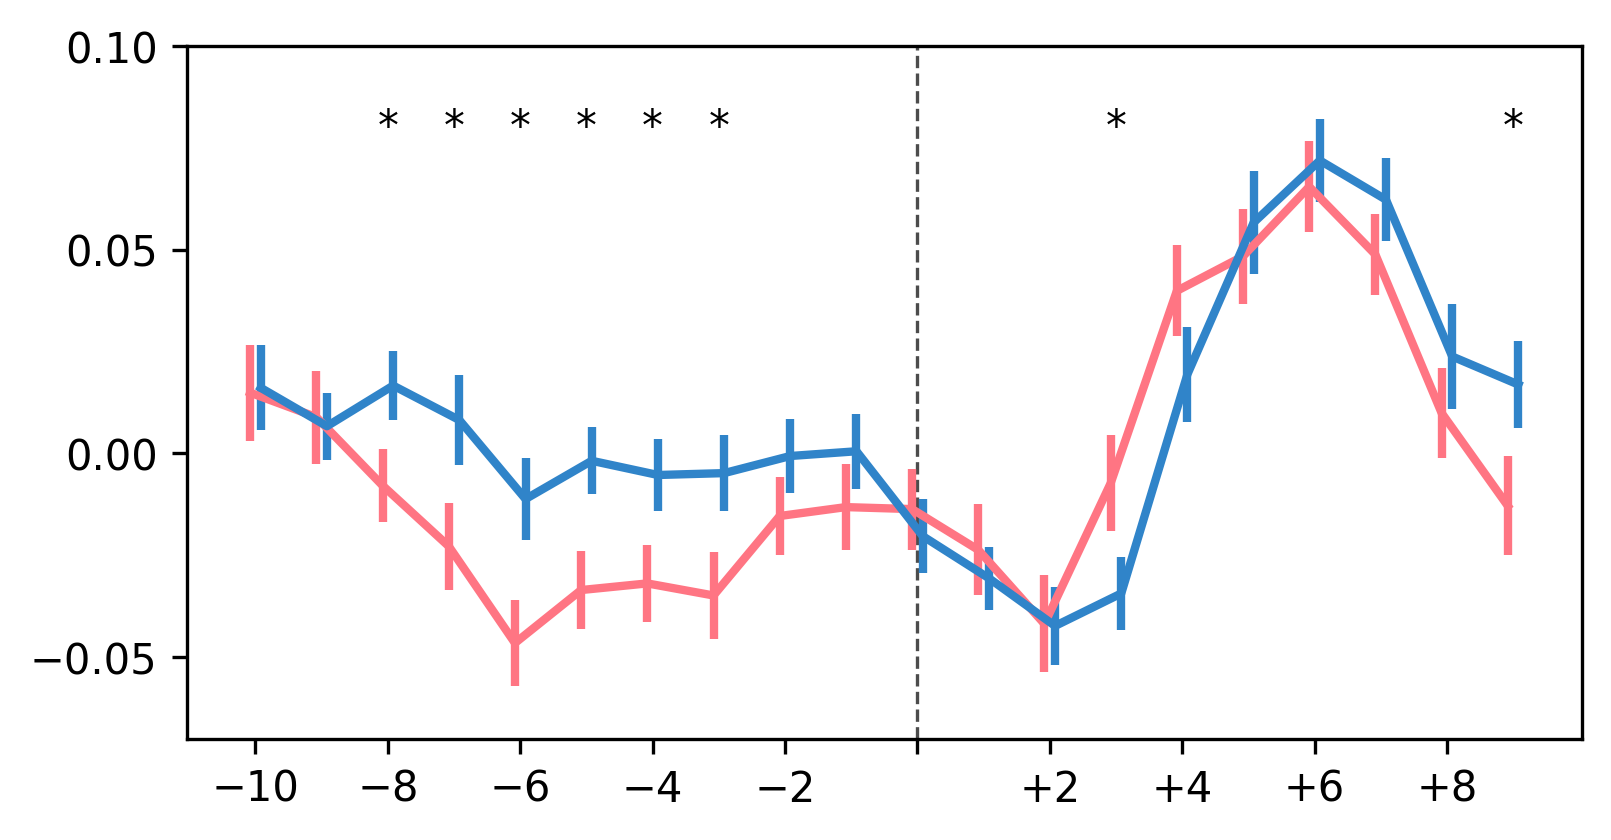

In [2]:
from scipy.stats import ttest_rel, ttest_ind, sem
plt.style.use('default')

all_event_boundaries = [34,  69,  103, 140, 176, 209, 243, 276, 313, 346, 382, 421, 458, 491, 527, 566, 599]
backward_retrieval_boundaries = [276, 313, 346, 382, 458, 491, 527, 566, 599]
forward_retrieval_boundaries = [103, 209, 276, 346, 421, 527, 566]

time_window = 10
forward_retrieval_activities = []
backward_retrieval_activities = []
for s, subject in enumerate(subjects):
    tmp_activity = []
    for e, end in enumerate(backward_retrieval_boundaries):
        tmp_activity.append(hippocampal_timeseries[s, end-time_window:end+time_window])
    backward_retrieval_activities.append(np.mean(tmp_activity, axis=0))

    tmp_activity = []
    for o, onset in enumerate(forward_retrieval_boundaries):
        tmp_activity.append(hippocampal_timeseries[s, onset-time_window:onset+time_window])
    forward_retrieval_activities.append(np.mean(tmp_activity, axis=0))

backward_retrieval_activities = np.array(backward_retrieval_activities).astype(np.double)
forward_retrieval_activities = np.array(forward_retrieval_activities).astype(np.double)

plt.figure(figsize=(6,3), dpi=300)
plt.axvline(x=time_window, c='k', lw=0.8, alpha=0.7, linestyle='--')

plt.errorbar(np.arange(time_window*2)-0.08,
             np.mean(forward_retrieval_activities, axis=0),
             yerr=sem(forward_retrieval_activities, axis=0),
             c='#ff7583', lw=2)

plt.errorbar(np.arange(time_window*2)+0.08,
             np.mean(backward_retrieval_activities, axis=0),
             yerr=sem(backward_retrieval_activities, axis=0),
             c='#3084c9', lw=2)

from statsmodels.stats.multitest import fdrcorrection
p_list = []
T_list = []
for t in range(time_window*2):
    T, p = ttest_rel(forward_retrieval_activities[:,t], backward_retrieval_activities[:,t])
    p_list.append(p)
    T_list.append(T)

iscorrected, p_corrected = fdrcorrection(p_list)
print(p_corrected)
for t in range(time_window*2):
    if p_corrected[t] < 0.001:
        plt.text(t, 0.08, '***', va='center', ha='center')
    elif p_corrected[t] < 0.01:
        plt.text(t, 0.08, '**', va='center', ha='center')
    elif p_corrected[t] < 0.05:
        plt.text(t, 0.08, '*', va='center', ha='center')
plt.ylim(-0.07, 0.1)

plt.xticks(np.arange(0, time_window*2, 2),
           ["−10", "−8", "−6", '−4','−2', ' ', '+2', "+4", '+6', "+8"])
plt.yticks([-0.05, 0.00, 0.05, 0.1])
plt.show()

In [3]:
T_list

[-0.11378003232893429,
 0.20884853705656678,
 -2.7356327552334054,
 -3.0107027410421607,
 -3.556545175821445,
 -3.121276023454946,
 -2.7480716230716826,
 -3.267241960016231,
 -1.630605768207775,
 -1.2195180515906272,
 0.7308183586150516,
 0.6727428142179006,
 0.05130580226745231,
 2.624748043425462,
 2.199618691749441,
 -0.7822934512101662,
 -0.6644866214529207,
 -1.2984191215098144,
 -1.3975715502586665,
 -2.449473470865724]